In [1]:
import GPy
import matplotlib.pylab as plt
import numpy as np
import scipy as sp

%matplotlib inline
np.random.seed(1)

Caching disabled: False


Want to do integral of $\int q(g_{i})q(f_{i})log p(y|f_{i},g_{i}) df_{i} dg_{i}$ with quadrature and sampling

In [2]:
X = np.linspace(0,5,100)[:, None]

kg = GPy.kern.RBF(1, lengthscale=2.0) + GPy.kern.White(1, variance=1e-5)
kf = GPy.kern.RBF(1, lengthscale=2.5)  + GPy.kern.White(1, variance=1e-5)
Kg = kg.K(X)
Kf = kf.K(X)
mf = np.ones((X.shape[0], 1))*0
mg = np.ones((X.shape[0], 1))*np.log(0.2) 

g = mg + GPy.util.linalg.jitchol(Kg).dot(np.random.randn(*X.shape))
f = mf + GPy.util.linalg.jitchol(Kf).dot(np.random.randn(*X.shape))

In [3]:
#True posterior
#Approximate, use prior for starting, plus some noise to make them different
qf_mean = mf + np.random.randn(*mf.shape)*1e-1
qg_mean = mg + np.random.randn(*mg.shape)*1e-1
qf_var = np.abs(np.diag(Kf)[:, None] + np.random.randn(*mf.shape)*1e-1)
qg_var = np.abs(np.diag(Kg)[:, None] + np.random.randn(*mf.shape)*1e-1)

mu = np.hstack((qf_mean, qg_mean))
var = np.hstack((qf_var, qg_var))

## Sampling idea

Kingma has a very simple reparameterization that reduces the variance gradients of a MCMC integration.

Essentially we want to do an integral of a unknown function, over a Gaussian, and to do the sampling, we will take many samples from the Gaussian, multiply them by the value of the unknown function at that point. The reparameterization says that instead of making a Gaussian that covers the entire region, sample from a univariate Gaussian, and stretch the point into the correct position, and evaluate at this point.

##Gaussian

Lets try do the integral for the Gaussian first using sampling and compare speeds

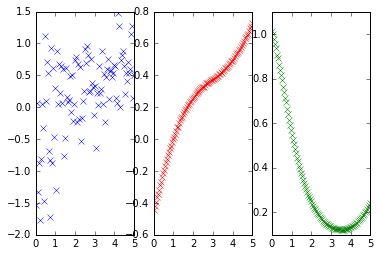

In [4]:
Ygauss = f + np.random.randn(*X.shape)*np.sqrt(np.exp(g)) + np.random.randn(*X.shape)*1e-5
fig, (ax1, ax2, ax3) = plt.subplots(1,3)
ax1.plot(X,Ygauss, 'bx')
ax2.plot(X,f, 'rx')
ax3.plot(X,np.exp(g), 'gx')

Do the integrals analytically and get the gradients

In [5]:
from chained_gp.hetgp import HetGP
hgp = HetGP()
int_logpy, int_logpy_dmu, int_logpy_dvar, int_logpy_dtheta = hgp.variational_expectations(Ygauss, mu, var)

Do the integrals vias sampling

In [6]:
#The function we wish to sample
def log_norm_func(z, y):
    #z is a sample from q(f,g)
    D = y.shape[1]
    fv, gv = z[:, :D], z[:, D:]
    e_g = np.exp(gv)
    y_f2 = (y-fv)**2
    res = -0.5*np.log(2*np.pi) - 0.5*gv - 0.5*(y_f2/e_g)
    return res

In [7]:
def get_unit_samples(m, v, num_samples=20000):
    #unit_norm = sp.stats.multivariate_normal(mean=np.zeros(2), cov=np.eye(2))
    #samp = unit_norm.rvs(num_samples)[:, None, :]
    samp = np.random.randn(num_samples, 1, 2)
    z = m[None, :, :] + np.sqrt(v[None, :, :])*samp
    z = np.rollaxis(z, 0, 3)  # put samples on the last dimension for broadcasting purposes
    return z
z = get_unit_samples(mu, var, num_samples=20000)

In [8]:
log_norm_func(z, Ygauss[:, :, None]).shape

(100, 1, 20000)

In [9]:
def variational_expectations_sampling(Y, mu, var, num_samples=20000):
    #Get the sample points
    samples = get_unit_samples(mu, var, num_samples=num_samples)
    # Need to add dimension to Y to broadcast it across samples
    #Evaluate at those sample points and take the mean over all the samples
    int_log_py_samp = np.mean(log_norm_func(samples, Ygauss[:, None]), -1)  
    return int_log_py_samp

In [10]:
def standard_sampling(Y, mu, var, num_samples=20000):
    f_samples = np.random.multivariate_normal(mean=mu[:,0], cov=np.diagflat(var[:,0]), size=num_samples)[None, :]
    g_samples = np.random.multivariate_normal(mean=mu[:,1], cov=np.diagflat(var[:,1]), size=num_samples)[None, :]
    samples = np.vstack((f_samples, g_samples))
    samples = np.swapaxes(samples, 0, 2)
    samples = np.swapaxes(samples, 1, 2)
    int_log_py_samp = np.mean(log_norm_func(samples, Ygauss[:, None]), -1)  
    return int_log_py_samp

Now lets compare speeds and accuracy of the sampling approach

In [11]:
num_samples = 150

In [12]:
int_log_py_samp = variational_expectations_sampling(Ygauss, mu, var, num_samples=num_samples)

In [13]:
int_log_py_samp_standard = standard_sampling(Ygauss, mu, var, num_samples=num_samples)

In [14]:
%timeit variational_expectations_sampling(Ygauss, mu, var, num_samples=num_samples)
%timeit hgp.variational_expectations(Ygauss, mu, var)
%timeit get_unit_samples(mu, var, num_samples=num_samples)
#samples = get_unit_samples(mu, var, num_samples=num_samples)
#%timeit log_norm_func(samples, Y[:, None])
#%timeit np.rollaxis(np.random.randn(num_samples, 2)[:, None, :], 0, 3)  # This is quick, its the computation that is slow

1000 loops, best of 3: 484 µs per loop
10000 loops, best of 3: 38.4 µs per loop
1000 loops, best of 3: 242 µs per loop


Turns out not to be super fast. About 1000 times slower (than the analytical, of course)

In [15]:
diff = np.abs(int_log_py_samp -  int_logpy)
diff = np.abs(int_log_py_samp_standard -  int_logpy)
print diff.min()
print diff.max()

0.0230357588693
5.39192579632


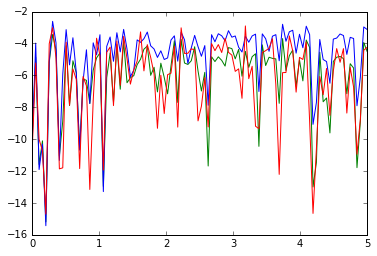

In [16]:
plt.plot(X, int_logpy, 'g')
plt.plot(X, int_log_py_samp, 'b')
plt.plot(X, int_log_py_samp_standard, 'r')

## Non-Gaussian functions
We will now look at non-Gaussian functions we would like to integrate and see how well quadrature compares to MC sampling

### The functions we wish to sample

In [17]:
def gauss_log_pdf(fv, gv, y):
    e_g = np.exp(gv)
    y_f2 = (y-fv)**2
    res = -0.5*np.log(2*np.pi) - 0.5*gv - 0.5*(y_f2/e_g)
    return res

In [18]:
from scipy.special import gammaln, gamma
deg_free=3.5
def stut_log_pdf(fv, gv, y):
    df = float(deg_free)
    y_f2 = (y-fv)**2
    lnpdf = gammaln(0.5*(df+1)) - gammaln(0.5*df) - 0.5*np.log(df*np.pi) - 0.5*gv - 0.5*(df+1)*np.log1p(y_f2/(df*np.exp(gv)))
    return lnpdf

In [19]:
from scipy.special import beta, betaln, gammaln, gamma, polygamma, zeta
from scipy.special import psi
def beta_log_pdf(fv, gv, y):
    ef = np.exp(fv)
    eg = np.exp(gv)
    lnpdf = (ef - 1)*np.log(y) + (eg - 1)*np.log(1-y) - betaln(ef, eg)
    return lnpdf

In [20]:
from scipy.stats import beta as beta_dist
from scipy.stats import t as stut
# Generate some data
Ybeta = [beta_dist.rvs(a=np.exp(fi), b=np.exp(gi)) for fi, gi in zip(f[:,0], g[:,0])]
Ybeta = np.asarray(Ybeta)[:, None]
Ystut = [stut.rvs(df=deg_free, loc=fi, scale=np.exp(gi)) for fi, gi in zip(f[:,0], g[:,0])]
Ystut = np.asarray(Ystut)[:, None]

We are going to look at the quality of the approximation as a bunch of points. We expect quadrature to do well in areas that can be well approximated by a lower order polynomial

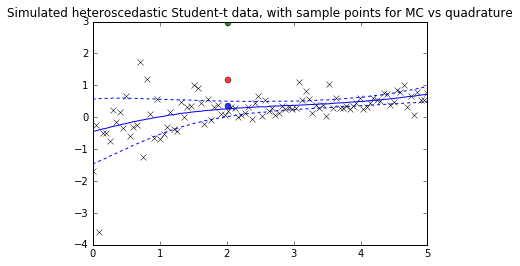

In [21]:
i = 10 
dist = 'stut'
if dist == 'stut':
    Y = Ystut 
    pdf_to_use = stut_log_pdf
elif dist =='beta':
    Y = Ybeta
    pdf_to_use = beta_log_pdf
else:
    Y = Ygauss
    pdf_to_use = gauss_log_pdf

Yi = Y[i:i+1, :]
Xi = X[i:i+1, :]
mi = mu[i:i+1, :]
vi = var[i:i+1, :]
zi = z[i:i+1, :]

#Close to the mode of the student-t is a value of Yi that is close to mu[i:i+1]
mode_ind = 40
Yi_mode = f[mode_ind:mode_ind+1, 0:1] + 0.1
Yi_tail = f[mode_ind:mode_ind+1, 0:1] + 0.9
Yi_far_tail = mu[mode_ind:mode_ind+1, 0:1] + 3.0

fig = plt.figure()
dashes = (3,3)
calpha = 0.8
ax1 = plt.subplot(1,1,1)
ax1.plot(X, Ystut, 'kx', mfc='none')
ax1.plot(X, f[:,0], 'b-')
ax1.plot(X, f[:,0] + np.exp(g[:,0]), 'b--', dashes=dashes)
ax1.plot(X, f[:,0] - np.exp(g[:,0]), 'b--', dashes=dashes)
plt.plot(X[mode_ind], Yi_mode, 'bo', alpha=calpha)
plt.plot(X[mode_ind], Yi_tail, 'ro', alpha=calpha)
plt.plot(X[mode_ind], Yi_far_tail, 'go', alpha=calpha)
ax1.set_title('Simulated heteroscedastic Student-t data, with sample points for MC vs quadrature')
#from matplotlib2tikz import save as tikz_save
#tikz_save('MCvsQuad_stut_process.tikz', figure=fig)

In [23]:
#Evaluate pdf for stut at the points
print("Tail pdf {}".format(np.exp(stut_log_pdf(mu[mode_ind:mode_ind+1, 0], var[mode_ind:mode_ind+1, 0], Yi_tail))))
print("Far tail pdf {}".format(np.exp(stut_log_pdf(mu[mode_ind:mode_ind+1, 0], var[mode_ind:mode_ind+1, 0], Yi_far_tail))))

Tail pdf [[ 0.16157392]]
Far tail pdf [[ 0.05175615]]


In [24]:
from chained_gp.hetgp import HetGP
hgp = HetGP()
# Use GPy code to do quadrature
int_logpyi, int_logpyi_dmu, int_logpyi_dvar, int_logpyi_dtheta = hgp.variational_expectations(Yi, mi, vi)

In [25]:
#The function we wish to sample
def log_func_mc(z, y):
    #z is a sample from q(f,g)
    D = y.shape[1]
    fv, gv = z[:, :D], z[:, D:]
    return pdf_to_use(fv, gv, y)

In [26]:
# Reparameterized sampling
def variational_expectations_sampling(Y, mu, var, num_samples=20000):
    samples = get_unit_samples(mu, var, num_samples=num_samples)
    # Need to add dimension to Y to broadcast it across samples
    int_log_py_samp = np.mean(log_func_mc(samples, Y[:, None]), -1)  
    return int_log_py_samp

In [27]:
# Standard high variance sampling
def standard_sampling(Y, mu, var, num_samples=20000):
    f_samples = np.random.multivariate_normal(mean=mu[:,0], cov=np.diagflat(var[:,0]), size=num_samples)[None, :]
    g_samples = np.random.multivariate_normal(mean=mu[:,1], cov=np.diagflat(var[:,1]), size=num_samples)[None, :]
    samples = np.vstack((f_samples, g_samples))
    samples = np.swapaxes(samples, 0, 2)
    samples = np.swapaxes(samples, 1, 2)
    int_log_py_samp = np.mean(log_func_mc(samples, Y[:, None]), -1)  
    return int_log_py_samp

In [28]:
# We care about how many function evaluations we require to obtain certain quality of approximations, 
# here we choose how many samples we are allowed to use
samples = np.array([2, 4, 8, 16, 32, 64, 128, 256])
repeats = 1000
num_datas = 5
rand_inds = np.random.randint(0, Y.shape[0], num_datas)
print "Chosen Y values: "
print Y[rand_inds]

Chosen Y values: 
[[ 0.54509553]
 [ 0.08584936]
 [ 0.05467862]
 [ 0.01679453]
 [ 0.2721031 ]]


In [29]:
samples_answer_mc_reparam = np.zeros((repeats, samples.shape[0], num_datas))
if dist == 'stut':
    #Do some specific indicies for the mode and tails aswell as random ones 
    samples_answer_mc_mode = np.zeros((repeats, samples.shape[0], 1))
    samples_answer_mc_tail = np.zeros((repeats, samples.shape[0], 1))
    samples_answer_mc_far_tail = np.zeros((repeats, samples.shape[0], 1))
    
# Repeat the MC samples several times to get an idea of how much variance we have in them
for n in range(repeats):
    if n % 100 == 0:
        print "repeats: ", n
    for s, num_s in enumerate(samples):
        if n == 0:
            print "Sample ", num_s
        num_s = num_s**2
        for i, ind in enumerate(rand_inds):
            #print "{} datapoint {}".format(i, ind)
            samples_answer_mc_reparam[n, s, i] = variational_expectations_sampling(Y[ind:ind+1,:], mu[ind:ind+1,:], var[ind:ind+1,:], num_samples=num_s)
        if dist == 'stut':
            samples_answer_mc_mode[n, s, 0] = variational_expectations_sampling(Yi_mode, mu[mode_ind:mode_ind+1,:], var[mode_ind:mode_ind+1,:], num_samples=num_s)
            samples_answer_mc_tail[n, s, 0] = variational_expectations_sampling(Yi_tail, mu[mode_ind:mode_ind+1,:], var[mode_ind:mode_ind+1,:], num_samples=num_s)
            samples_answer_mc_far_tail[n, s, 0] = variational_expectations_sampling(Yi_far_tail, mu[mode_ind:mode_ind+1,:], var[mode_ind:mode_ind+1,:], num_samples=num_s)

repeats:  0
Sample  2
Sample  4
Sample  8
Sample  16
Sample  32
Sample  64
Sample  128
Sample  256
repeats:  100
repeats:  200
repeats:  300
repeats:  400
repeats:  500
repeats:  600
repeats:  700
repeats:  800
repeats:  900


In [30]:
#No need to do this, it is the same, it just give shigher variance estimates
#samples_answer_mc = np.zeros((repeats, samples.shape[0], num_datas))
#for i, ind in enumerate(rand_inds):
#    print ind
#    for s, num_s in enumerate(samples):
#        print "Sample ", num_s
#        num_s = num_s**2
#        for n in range(repeats):
#            samples_answer_mc[n, s, i] = standard_sampling(Y[ind:ind+1,:], mu[ind:ind+1,:], var[ind:ind+1,:], num_samples=num_s)

Now do the same with quadrature

In [31]:
from chained_gp.multi_likelihood import MultiLikelihood
from GPy.likelihoods.link_functions import Identity
m = MultiLikelihood(Identity(), 'multi')
samples_answer_quad = np.zeros((1, samples.shape[0], num_datas))*np.nan

if dist == 'stut':
    #Do some specific indicies for the mode and tails aswell as random ones 
    samples_answer_quad_mode = np.zeros((1, samples.shape[0], 1))
    samples_answer_quad_tail = np.zeros((1, samples.shape[0], 1))
    samples_answer_quad_far_tail = np.zeros((1, samples.shape[0], 1))

for s, num_s in enumerate(samples):
    #print "s: ", s
    gh = np.polynomial.hermite.hermgauss(num_s)
    for i, ind in enumerate(rand_inds):
        #print "i: ", i
        try:
            samples_answer_quad[0, s, i] = m.quad2d([pdf_to_use], Y[ind:ind+1,:], mu[ind:ind+1,0:1], var[ind:ind+1,0:1], mu[ind:ind+1,1:2], var[ind:ind+1,1:2], gh_points=gh)[0]
        except:
            print "Failed, naning"
            samples_answer_quad[0, s, i] = np.nan
    if dist == 'stut':
        try:
            samples_answer_quad_mode[0, s, 0] = m.quad2d([pdf_to_use], Yi_mode, mu[mode_ind:mode_ind+1,0:1], var[mode_ind:mode_ind+1,0:1], mu[mode_ind:mode_ind+1,1:2], var[mode_ind:mode_ind+1,1:2], gh_points=gh)[0]
        except:
            print "Failed, naning"
            samples_answer_quad_mode[0, s, 0] = np.nan
        try:
            samples_answer_quad_tail[0, s, 0] = m.quad2d([pdf_to_use], Yi_tail, mu[mode_ind:mode_ind+1,0:1], var[mode_ind:mode_ind+1,0:1], mu[mode_ind:mode_ind+1,1:2], var[mode_ind:mode_ind+1,1:2], gh_points=gh)[0]
        except:
            print "Failed, naning"
            samples_answer_quad_tail[0, s, 0] = np.nan
        try:
            samples_answer_quad_far_tail[0, s, 0] = m.quad2d([pdf_to_use], Yi_far_tail, mu[mode_ind:mode_ind+1,0:1], var[mode_ind:mode_ind+1,0:1], mu[mode_ind:mode_ind+1,1:2], var[mode_ind:mode_ind+1,1:2], gh_points=gh)[0]
        except:
            print "Failed, naning"
            samples_answer_quad_far_tail[0, s, 0] = np.nan

In [32]:
# Use MC with many samples as the ground truth to compare with, as we dont have the analytic solution, i.e. the last column
ground_truth = np.mean(samples_answer_mc_reparam[:, -1, :], 0)
if dist == 'stut':
    ground_truth_mode = np.mean(samples_answer_mc_mode[:, -1, :], 0)
    ground_truth_tail = np.mean(samples_answer_mc_tail[:, -1, :], 0)
    ground_truth_far_tail = np.mean(samples_answer_mc_far_tail[:, -1, :], 0)
print ground_truth
print ground_truth.shape
print samples_answer_mc_reparam.shape

[-2.20337111 -1.8194525  -1.77252084 -1.99510456 -1.93909849]
(5,)
(1000, 8, 5)


In [33]:
ground_truth_mode

array([-2.05666992])

In [34]:
samples_answer_quad_mode

array([[[-2.45580566],
        [-2.10377702],
        [-2.02487053],
        [-2.04026881],
        [-2.05610329],
        [-2.05743487],
        [-2.05684747],
        [-2.05691659]]])

In [35]:
samples_answer_quad_tail

array([[[-2.71027919],
        [-2.98435213],
        [-3.08343398],
        [-3.04109395],
        [-3.05101508],
        [-3.04968448],
        [-3.04941161],
        [-3.04941037]]])

In [36]:
samples_answer_quad_far_tail

array([[[-6.03986406],
        [-6.03563811],
        [-6.03945807],
        [-6.03964902],
        [-6.03995759],
        [-6.03990683],
        [-6.03990831],
        [-6.03990926]]])

In [37]:
#error_per_repeat_mc = samples_answer_mc - ground_truth
error_per_repeat_mc_reparam = ground_truth - samples_answer_mc_reparam
error_per_repeat_quad = ground_truth - samples_answer_quad
abs_err_reparam = np.abs(error_per_repeat_mc_reparam)
abs_err_quad = np.abs(error_per_repeat_quad)

if dist == 'stut':
    error_per_repeat_mc_mode = ground_truth_mode - samples_answer_mc_mode
    error_per_repeat_quad_mode = ground_truth_mode - samples_answer_quad_mode
    abs_err_mc_mode = np.abs(error_per_repeat_mc_mode)
    abs_err_quad_mode = np.abs(error_per_repeat_quad_mode)
    
    error_per_repeat_mc_tail = ground_truth_tail - samples_answer_mc_tail
    error_per_repeat_quad_tail = ground_truth_tail - samples_answer_quad_tail
    abs_err_mc_tail = np.abs(error_per_repeat_mc_tail)
    abs_err_quad_tail = np.abs(error_per_repeat_quad_tail)
    
    error_per_repeat_mc_far_tail = ground_truth_far_tail - samples_answer_mc_far_tail
    error_per_repeat_quad_far_tail = ground_truth_far_tail - samples_answer_quad_far_tail
    abs_err_mc_far_tail = np.abs(error_per_repeat_mc_far_tail)
    abs_err_quad_far_tail = np.abs(error_per_repeat_quad_far_tail)

In [38]:
ground_truth

array([-2.20337111, -1.8194525 , -1.77252084, -1.99510456, -1.93909849])

Lets plot the absolute errors for a random point, the mode, and the variance.

In [39]:
d = 2
print "{}, {}".format(X[rand_inds[d]], Y[rand_inds[d]])

[ 2.52525253], [ 0.05467862]


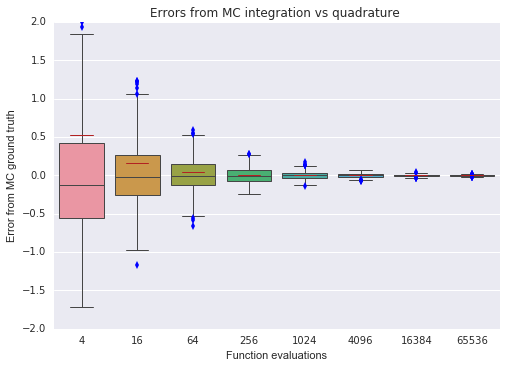

In [45]:
import seaborn
lw = 1.0

fig, compare_error = plt.subplots(1,1)
seaborn.boxplot(data=error_per_repeat_mc_reparam[:, :, d], ax=compare_error, linewidth=lw)
compare_error.set_xticklabels(samples**2)
compare_error.set_xlabel('Function evaluations')
compare_error.set_ylabel('Error from MC ground truth')
compare_error.set_title('Errors from MC integration vs quadrature ')

medianprops = dict(linestyle='-.', linewidth=2.5, color='firebrick')
for i, v in enumerate((np.arange(0,samples.shape[0]))):
    #print v
    line = np.linspace(v - 0.2, v + 0.2, 2)
    val = np.ones_like(line)*error_per_repeat_quad[0, i, d]#[0, i]
    compare_error.plot(line, val, '-', color='firebrick', linewidth=lw)

compare_error.set_ylim(-2, 2)

#plt.rcParams['text.latex.unicode']=True
plt.rcParams['text.usetex']=False
plt.rcParams['pgf.texsystem'] = 'pdflatex'
#fig.savefig('corrupt_motorcycleeps.eps', dpi=500)

#from matplotlib2tikz import save as tikz_save
#tikz_save('MCvsQuad.tikz', figure=fig)

Ignore the last quadrature point as it is null

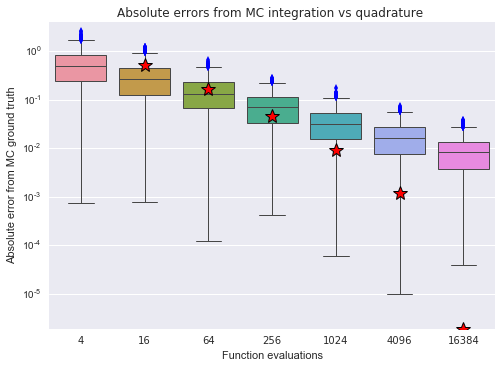

In [46]:
import seaborn
lw = 1.0
d = 2
fig, compare_abs_error = plt.subplots(1,1)
seaborn.boxplot(data=abs_err_reparam[:, :-1, d], ax=compare_abs_error, linewidth=lw)
compare_abs_error.set_xticklabels(samples**2)
compare_abs_error.set_xlabel('Function evaluations')
compare_abs_error.set_ylabel('Absolute error from MC ground truth')
compare_abs_error.set_title('Absolute errors from MC integration vs quadrature ')

compare_abs_error.plot(np.arange(0, samples.shape[0]-1)+1, abs_err_quad[0, :-1, d], 'r*', markersize=15, markeredgewidth=1)
compare_abs_error.semilogy()
compare_abs_error.set_ylim(0, 4)

#plt.rcParams['text.latex.unicode']=True
plt.rcParams['text.usetex']=False
plt.rcParams['pgf.texsystem'] = 'pdflatex'
#fig.savefig('corrupt_motorcycleeps.eps', dpi=500)

#from matplotlib2tikz import save as tikz_save
#tikz_save('MCvsQuad_abslog_stut.tikz', figure=fig)

Mode of student-t

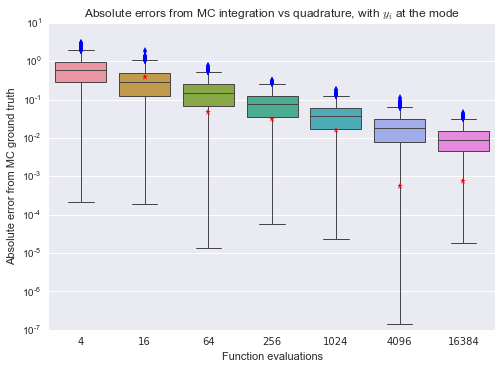

In [47]:
if dist == 'stut':
    import seaborn
    lw = 1.0
    fig_mode, compare_abs_error = plt.subplots(1,1)
    seaborn.boxplot(data=abs_err_mc_mode[:, :-1, 0], ax=compare_abs_error, linewidth=lw)
    compare_abs_error.set_xticklabels(samples**2)
    compare_abs_error.set_xlabel('Function evaluations')
    compare_abs_error.set_ylabel('Absolute error from MC ground truth')
    compare_abs_error.set_title(r'Absolute errors from MC integration vs quadrature, with $y_{i}$ at the mode')

    compare_abs_error.plot(np.arange(0, samples.shape[0]-1)+1, abs_err_quad_mode[0, :-1, 0], 'r*')
    compare_abs_error.semilogy()
    #compare_abs_error.set_ylim(0, 4)

    #plt.rcParams['text.latex.unicode']=True
    plt.rcParams['text.usetex']=False
    plt.rcParams['pgf.texsystem'] = 'pdflatex'
    #fig.savefig('corrupt_motorcycleeps.eps', dpi=500)

    #from matplotlib2tikz import save as tikz_save
    #tikz_save('MCvsQuad_abslog_stut_mode.tikz', figure=fig_mode)

Shoulder of student-t

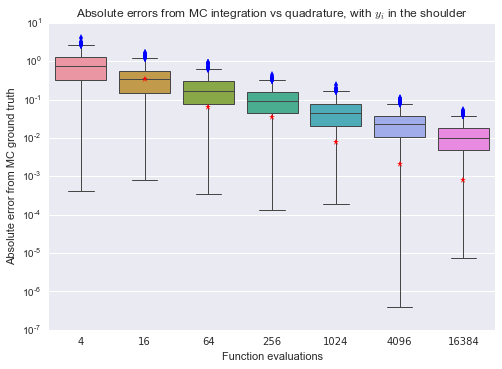

In [50]:
if dist == 'stut':
    import seaborn
    lw = 1.0
    fig_tail, compare_abs_error = plt.subplots(1,1)
    seaborn.boxplot(data=abs_err_mc_tail[:, :-1, 0], ax=compare_abs_error, linewidth=lw)
    compare_abs_error.set_xticklabels(samples**2)
    compare_abs_error.set_xlabel('Function evaluations')
    compare_abs_error.set_ylabel('Absolute error from MC ground truth')
    compare_abs_error.set_title('Absolute errors from MC integration vs quadrature, with $y_{i}$ in the shoulder')

    compare_abs_error.plot(np.arange(0, samples.shape[0]-1)+1, abs_err_quad_tail[0, :-1, 0], 'r*')
    compare_abs_error.semilogy()
    #compare_abs_error.set_ylim(0, 4)

    #plt.rcParams['text.latex.unicode']=True
    plt.rcParams['text.usetex']=False
    plt.rcParams['pgf.texsystem'] = 'pdflatex'
    #fig.savefig('corrupt_motorcycleeps.eps', dpi=500)

    #from matplotlib2tikz import save as tikz_save
    #tikz_save('MCvsQuad_abslog_stut_shoulder.tikz', figure=fig)

far tail student-t

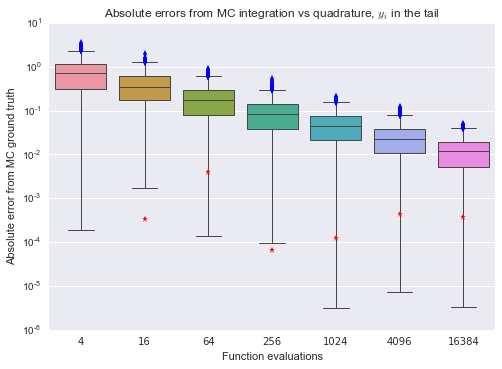

In [52]:
if dist == 'stut':
    import seaborn
    lw = 1.0
    fig_tail, compare_abs_error = plt.subplots(1,1)
    seaborn.boxplot(data=abs_err_mc_far_tail[:, :-1, 0], ax=compare_abs_error, linewidth=lw)
    compare_abs_error.set_xticklabels(samples**2)
    compare_abs_error.set_xlabel('Function evaluations')
    compare_abs_error.set_ylabel('Absolute error from MC ground truth')
    compare_abs_error.set_title('Absolute errors from MC integration vs quadrature, $y_{i}$ in the tail')

    compare_abs_error.plot(np.arange(0, samples.shape[0]-1)+1, abs_err_quad_far_tail[0, :-1, 0], 'r*')
    compare_abs_error.semilogy()
    #compare_abs_error.set_ylim(0, 4)

    #plt.rcParams['text.latex.unicode']=True
    plt.rcParams['text.usetex']=False
    plt.rcParams['pgf.texsystem'] = 'pdflatex'
    #fig.savefig('corrupt_motorcycleeps.eps', dpi=500)

    #from matplotlib2tikz import save as tikz_save
    #tikz_save('MCvsQuad_abslog_stut_far_tail.tikz', figure=fig)

## Investiation of the integration being made - Beta only

In [83]:
ind = rand_inds[d]
Yi = Y[ind:ind+1,0:1]
qf_meani = np.sum(mu[ind:ind+1,0:1])
qg_meani = np.sum(mu[ind:ind+1,1:2])
qf_vari = np.sum(var[ind:ind+1,0:1]) + 5.0
qg_vari = np.sum(var[ind:ind+1,1:2])

In [84]:
x_range = np.linspace(-5,5,50)[:, None]
py_f = sp.stats.norm.pdf(x_range, loc=qf_meani, scale=np.sqrt(qf_vari))
py_g = sp.stats.norm.pdf(x_range, loc=qg_meani, scale=np.sqrt(qg_vari))

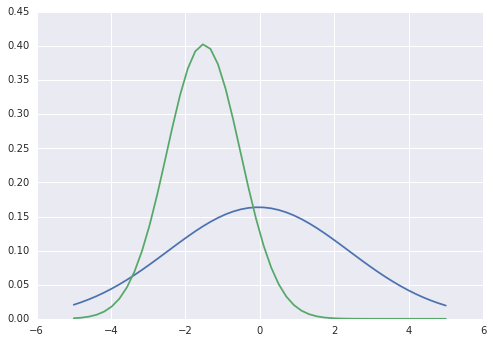

In [85]:
#Convolving a 2d Gaussian with these means and variances with a Beta
plt.plot(x_range, py_f)
plt.plot(x_range, py_g)

In [86]:
qf_range = np.linspace(np.sum(qf_meani - 3*np.sqrt(qf_vari)), np.sum(qf_meani + 3*np.sqrt(qf_vari)), 30)
qg_range = np.linspace(np.sum(qg_meani - 3*np.sqrt(qg_vari)), np.sum(qg_meani + 3*np.sqrt(qg_vari)), 30)

In [87]:
XX, YY = np.meshgrid(qf_range, qg_range)

In [88]:
qf_meani + 3*np.sqrt(qf_vari)

7.2813115130728372

In [89]:
qf_meani - 3*np.sqrt(qf_vari)

-7.3503089551038334

In [90]:
XX_shape = XX.shape
YY_shape = YY.shape
if dist == 'beta':
    py_f = np.array([sp.stats.beta.pdf(Yi, np.exp(mi), np.exp(vi)) for mi, vi in zip(XX.reshape(-1), YY.reshape(-1))])
    ZZ = py_f.reshape(XX.shape)
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(XX, YY, ZZ, cstride=1, rstride=1)
else:
    raise NotImplementedError    
#pg = np.array([sp.stats.norm.pdf(Yi, loc=qf_meani, scale=np.sqrt(np.exp(qf_vari))) for mi, vi in zip(XX.reshape(-1), YY.reshape(-1))])

NotImplementedError: 

In [91]:
from scipy.stats import multivariate_normal
#multivariate_normal([np.sum(qf_meani), np.sum(qg_meani)], [[2.0, 0.3], [0.3, 0.5]])
rv = multivariate_normal([np.sum(qf_meani), np.sum(qg_meani)], [[np.sum(qf_vari), 0],[0, np.sum(qg_vari)]])

In [92]:
#Evaluate the pdf of the independent q(f) and q(g)
pos = np.empty(XX.shape + (2,))
pos[:, :, 0] = XX; pos[:, :, 1] = YY
ZZnorm = rv.pdf(pos)

NameError: name 'ZZ' is not defined

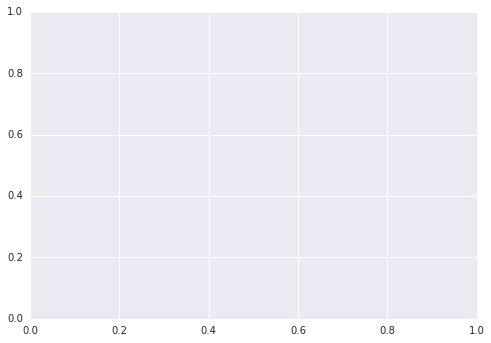

In [93]:
fig2, ax2 = plt.subplots(1,1)
extent = [qf_range.min(), qf_range.max(), qg_range.min(), qg_range.max()]
im = ax2.imshow(ZZ, alpha=0.5, extent=extent)
extent = [XX.min(), XX.max(), YY.min(), YY.max()]
ax2.imshow(ZZnorm, alpha=0.5, extent=extent)

In [ ]:
gh = np.polynomial.hermite.hermgauss(np.round(np.sqrt(num_samples)))

In [95]:
q_meansi =  np.hstack([qf_meani, qg_meani])[None, :]
q_varsi = np.hstack([qf_vari, qg_vari])[None, :]

In [96]:
num_samples = 100
samples = get_unit_samples(q_meansi, q_varsi, num_samples=num_samples)
samples.shape

(1, 2, 100)

Get GH points

In [73]:
gh = np.polynomial.hermite.hermgauss(np.sqrt(num_samples))

In [97]:
ghx = gh[0]*np.sqrt(2*q_varsi[0, 0]) + q_meansi[0,0]
ghy = gh[0]*np.sqrt(2*q_varsi[0, 1]) + q_meansi[0,1]

In [98]:
ghxy = np.array(zip(ghx, ghy))

In [99]:
ghxy

array([[-11.88480135,  -6.3245593 ],
       [ -8.76914569,  -5.05831185],
       [ -6.09278419,  -3.97059989],
       [ -3.60946473,  -2.961343  ],
       [ -1.21706459,  -1.98903704],
       [  1.14806715,  -1.02781335],
       [  3.54046729,  -0.05550739],
       [  6.02378675,   0.9537495 ],
       [  8.70014824,   2.04146146],
       [ 11.81580391,   3.30770891]])

In [100]:
#ghXX, ghYY = np.meshgrid(ghx, ghy)
ghXX = np.repeat(ghx, ghy.shape[0])
ghYY = np.tile(ghy, ghy.shape[0])

NameError: name 'ZZ' is not defined

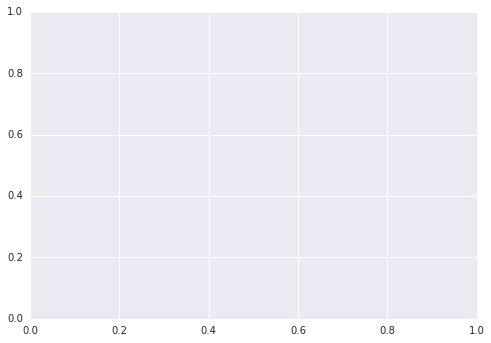

In [101]:
fig3, ax3 = plt.subplots(1,1)
extent = [ghXX.min(), ghXX.max(), ghYY.min(), ghYY.max()]
im = ax3.imshow(ZZ, alpha=1.0, extent=extent)
ax3.imshow(ZZnorm, alpha=0.5, extent=extent)
#im = ax3.imshow(ZZ + ZZnorm, extent=extent)
plt.plot(ghXX, ghYY, 'go')
plt.plot(samples[0,0,:], samples[0,1,:], 'rx')
plt.xlim(ghXX.min(), ghXX.max())
plt.ylim(ghYY.min(), ghYY.max())
# Although they are laid out in a grid, their weights will be stronger in the middle of the Gaussian than the outside.
# This simply shows where the GH points will be used, with not enough points, we won't cover essential parts of the PDF

##Beta distibution
The previous was an unfair test as it was analytic.

Maybe the speed up is much better for a operator that needs quadrature

In [102]:
from scipy.stats import beta as beta_dist
Ybeta = [beta_dist.rvs(a=np.exp(fi), b=np.exp(gi)) for fi, gi in zip(f[:,0], g[:,0])]
Ybeta = np.asarray(Ybeta)[:, None]

In [103]:
from chained_gp.het_beta import HetBeta
hbeta = HetBeta()
int_logpy_beta, int_logpy_dmu_beta, int_logpy_dvar_beta, int_logpy_dtheta_beta = hbeta.variational_expectations(Ybeta, mu, var)

In [104]:
#The function we wish to sample
from scipy.special import beta, betaln, gammaln, gamma, polygamma, zeta
from scipy.special import psi
def log_beta_func(z, y, Y_metadata=None):
    D = y.shape[1]
    fv, gv = f[:, :D], f[:, D:]
    ef = np.exp(fv)
    eg = np.exp(gv)
    lnpdf = (ef - 1)*np.log(y) + (eg - 1)*np.log(1-y) - betaln(ef, eg)
    return lnpdf

In [105]:
def beta_variational_expectations_sampling(Y, mu, var, num_samples=20000):
    samples = get_unit_samples(mu, var, num_samples=num_samples)
    # Need to add dimension to Y to broadcast it across samples
    int_log_py_samp = (1.0/num_samples)*np.sum(log_beta_func(samples,Y[:, None]), -1)  
    return int_log_py_samp

In [106]:
int_log_py_samp_beta = beta_variational_expectations_sampling(Ybeta, mu, var, num_samples=num_samples)

In [107]:
%timeit hbeta.variational_expectations(Y, mu, var)
%timeit beta_variational_expectations_sampling(Ybeta, mu, var, num_samples=num_samples)

100 loops, best of 3: 10.8 ms per loop
1000 loops, best of 3: 222 µs per loop


In [108]:
diff = np.abs(int_log_py_samp -  int_logpy)
print diff.min()
print diff.max()

0.00538385337756
3.92855630776
